#### 18 Oct: Try to query several flights from phase of flight as dataframes, caclulate columns and plot their differences

In [2]:
%pip install awswrangler --quiet
import boto3
import awswrangler as wr
import pandas as pd
from re import sub 

session = boto3.Session() 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 3.3.0 which is incompatible.
spyder 5.3.3 requires ipython<8.0.0,>=7.31.1, but you have ipython 8.16.1 which is incompatible.
spyder 5.3.3 requires pylint<3.0,>=2.5.0, but you have pylint 3.0.1 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Query Athena

In [3]:
from functools import partial

fetch = partial(wr.athena.read_sql_query, 
                database='universityose_db', 
                boto3_session=session, 
                s3_output='s3://universityose-bucket/yvlcmb/awswrangler/')

In [4]:
flights = fetch(sql="SELECT flightid, COUNT(*) AS rows FROM phase_of_flight WHERE year IN ('2022', '2023') GROUP BY (flightid) ORDER BY rows")

## Sample flights provided to GMU group
* 16th of February 2023
* 26th Januray 2023
* 20th October 2022
* 6th October 2022

In [5]:
def parse_dataframe(in_df): 
    df = in_df.copy()
    df['platform'] = df.flightid.str.slice(0,6)
    df['start'] = df.flightid.str.slice(7,22)
    df['stop'] = df.flightid.str.slice(23)
    df['year'] = df.flightid.str.slice(7,11)
    df['month'] = df.flightid.str.slice(11,13)
    df['day'] = df.flightid.str.slice(13,15)
    df['ymd'] = df.year + df.month + df.day
    return df
                            

In [6]:
df = parse_dataframe(flights)

In [7]:
low_g_df = df[df.ymd.isin(('20230216', '20230126', '20221020', '20221006'))]

In [203]:
low_g_df

flightid    rows platform            start  \
96   0eb374_20230216T191250_20230216T191559    8165   0eb374  20230216T191250   
183  0eb374_20230126T170430_20230126T171126   16439   0eb374  20230126T170430   
186  0eb374_20230216T191746_20230216T192349   16752   0eb374  20230216T191746   
192  0eb374_20230126T205028_20230126T205649   17637   0eb374  20230126T205028   
281  0eb374_20221006T191600_20221006T192750   29373   0eb374  20221006T191600   
299  0eb374_20230126T165108_20230126T170201   32327   0eb374  20230126T165108   
316  0eb374_20230126T191506_20230126T193309   34934   0eb374  20230126T191506   
334  0eb374_20230216T151400_20230216T152827   38713   0eb374  20230216T151400   
343  0eb374_20230216T154219_20230216T155835   43701   0eb374  20230216T154219   
363  0eb374_20230126T184242_20230126T190150   51732   0eb374  20230126T184242   
374  0eb374_20221020T164314_20221020T170607   55280   0eb374  20221020T164314   
379  31dcb8_20221006T134902_20221006T141008   56550   31dcb8  20221006T134902   
417  0eb374_20221006T193742_20221006T201246   80102   0eb374  20221006T193742   
421  31dcb8_20230216T144106_20230216T151110   83367   31dcb8  20230216T144106   
429  0eb374_20221020T211929_20221020T220157   98793   0eb374  20221020T211929   
441  0eb374_20230126T142217_20230126T150306  113990   0eb374  20230126T142217   
445  0eb374_20221020T200728_20221020T210436  127083   0eb374  20221020T200728   

                stop  year month day       ymd  
96   20230216T191559  2023    02  16  20230216  
183  20230126T171126  2023    01  26  20230126  
186  20230216T192349  2023    02  16  20230216  
192  20230126T205649  2023    01  26  20230126  
281  20221006T192750  2022    10  06  20221006  
299  20230126T170201  2023    01  26  20230126  
316  20230126T193309  2023    01  26  20230126  
334  20230216T152827  2023    02  16  20230216  
343  20230216T155835  2023    02  16  20230216  
363  20230126T190150  2023    01  26  20230126  
374  20221020T170607  2022    10  20  20221020  
379  20221006T141008  2022    10  06  20221006  
417  20221006T201246  2022    10  06  20221006  
421  20230216T151110  2023    02  16  20230216  
429  20221020T220157  2022    10  20  20221020  
441  20230126T150306  2023    01  26  20230126  
445  20221020T210436  2022    10  20  20221020

In [8]:
low_g = low_g_df.flightid.tolist()

In [9]:
columns_and_aliases = {
    "flightid": "flightid", 
    "times_seconds":"seconds",
    "flightstate_position_pitch":"pitch", 
    "flightstate_position_roll":"roll",
    "flightstate_speeds_trueairspeed":"speed", 
    "flightstate_rates_climbordescentrate":"descent"
}

In [10]:
def create_sql_from_flightid(flightid, cols=columns_and_aliases):
    contents = flightid.split('_')
    t1, t2 = contents[1:]
    year = t1[:4]
    month = t1[4:6]
    day = t1[6:8]
    ymd = '-'.join((year,month,day))
    hour1 = t1[-6:]
    hour2 = t2[-6:]
    ts1 = ':'.join((hour1[-6:-4], hour1[-4:-2], hour1[-2:]+'.000'))
    ts2 = ':'.join((hour2[-6:-4], hour2[-4:-2], hour2[-2:]+'.000'))
    sql_query = ''.join((
        'SELECT ', 
        *[f'{k} AS {v}, ' for k, v in columns_and_aliases.items()], 
        "FROM flight_details ", 
        f"WHERE year='{year}' ",
        f"AND month='{month}' ",
        f"AND times_gpsdatetime > CAST('{ymd} {ts1}' AS timestamp) ",
        f"AND times_gpsdatetime < CAST('{ymd} {ts2}' AS timestamp)"))
    return sub(', FROM', ' FROM', sql_query)

In [225]:
create_sql_from_flightid(low_g[0])

"SELECT flightid AS flightid, times_seconds AS seconds, flightstate_position_pitch AS pitch, flightstate_position_roll AS roll, flightstate_speeds_trueairspeed AS speed, flightstate_rates_climbordescentrate AS descent FROM flight_details WHERE year='2023' AND month='02' AND times_gpsdatetime > CAST('2023-02-16 19:12:50.000' AS timestamp) AND times_gpsdatetime < CAST('2023-02-16 19:15:59.000' AS timestamp)"

In [224]:
for flight in low_g:
    df = fetch(create_sql_from_flightid(flight))
    print(f'{flight}: {len(df)}')

0eb374_20230216T191250_20230216T191559: 8125
0eb374_20230126T170430_20230126T171126: 16408
0eb374_20230216T191746_20230216T192349: 16739
0eb374_20230126T205028_20230126T205649: 17593
0eb374_20221006T191600_20221006T192750: 29363
0eb374_20230126T165108_20230126T170201: 32288
0eb374_20230126T191506_20230126T193309: 34890
0eb374_20230216T151400_20230216T152827: 38670
0eb374_20230216T154219_20230216T155835: 43664
0eb374_20230126T184242_20230126T190150: 51687
0eb374_20221020T164314_20221020T170607: 55258
31dcb8_20221006T134902_20221006T141008: 56539
0eb374_20221006T193742_20221006T201246: 80093
31dcb8_20230216T144106_20230216T151110: 83341
0eb374_20221020T211929_20221020T220157: 98767
0eb374_20230126T142217_20230126T150306: 113971
0eb374_20221020T200728_20221020T210436: 127070


In [11]:
frames = []
for flight in low_g:
    df = fetch(create_sql_from_flightid(flight))
    diff_cols = [{'_'.join((col, 'diff')): df[col].diff() for col in df.columns.to_list()[1:]}]
    for data in diff_cols:
        for key, val in data.items(): 
            df[key] = pd.Series(val)
    frames.append(df)


#### Trying to plot each frame individually, rather than in one combined chart, nothing I tried works so far

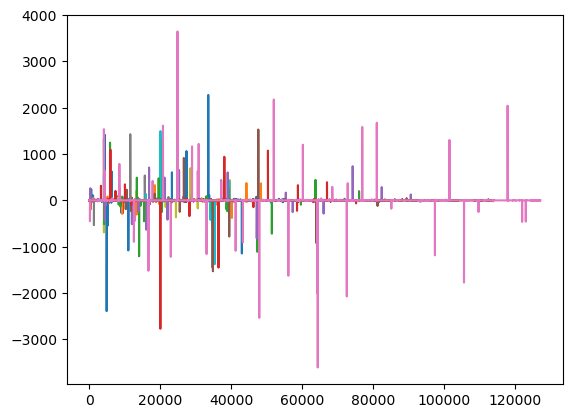

In [231]:
# for some reason all of them are plotted in a single frame, it would be better to have 17 individual plots
for frame in frames: 
    frame.descent_diff.plot() 

<AxesSubplot:>

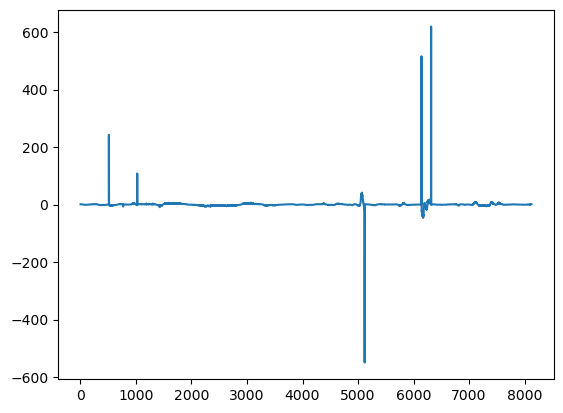

In [232]:
frames[0].descent_diff.plot()

In [238]:
frames[1]

flightid       seconds  pitch   roll  \
0      0eb374_20230126T170430_20230126T171126  1.674753e+09 -0.507 -0.061   
1      0eb374_20230126T170430_20230126T171126  1.674753e+09 -0.507 -0.061   
2      0eb374_20230126T170430_20230126T171126  1.674753e+09 -0.507 -0.061   
3      0eb374_20230126T170430_20230126T171126  1.674753e+09 -0.507 -0.061   
4      0eb374_20230126T170430_20230126T171126  1.674753e+09 -0.507 -0.061   
...                                       ...           ...    ...    ...   
16403  0eb374_20230126T170430_20230126T171126  1.674753e+09 -0.508 -0.084   
16404  0eb374_20230126T170430_20230126T171126  1.674753e+09 -0.508 -0.084   
16405  0eb374_20230126T170430_20230126T171126  1.674753e+09 -0.507 -0.084   
16406  0eb374_20230126T170430_20230126T171126  1.674753e+09 -0.507 -0.084   
16407  0eb374_20230126T170430_20230126T171126  1.674753e+09 -0.507 -0.084   

       speed  descent  seconds_diff  pitch_diff  roll_diff  speed_diff  \
0        0.0    0.033           NaN         NaN        NaN         NaN   
1        0.0    0.033         0.027       0.000        0.0         0.0   
2        0.0    0.033         0.033       0.000        0.0         0.0   
3        0.0    0.033         0.030       0.000        0.0         0.0   
4        0.0    0.033         0.026       0.000        0.0         0.0   
...      ...      ...           ...         ...        ...         ...   
16403    0.0    0.001         0.026       0.000        0.0         0.0   
16404    0.0    0.001         0.026       0.000        0.0         0.0   
16405    0.0    0.001         0.028       0.001        0.0         0.0   
16406    0.0    0.001         0.031       0.000        0.0         0.0   
16407    0.0    0.001         0.026       0.000        0.0         0.0   

       descent_diff  
0               NaN  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
...             ...  
16403           0.0  
16404           0.0  
16405           0.0  
16406           0.0  
16407           0.0  

[16408 rows x 11 columns]

<AxesSubplot:title={'center':'0eb374_20230126T170430_20230126T171126'}>

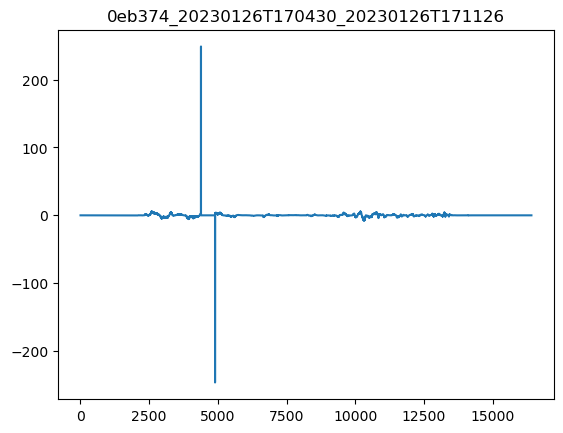

In [240]:
# I would like this type of plot for each frame in the list of 17 dataframes: 
frames[1]['descent_diff'].plot(title=frames[1]['flightid'].iloc[0])

<AxesSubplot:title={'center':'0eb374_20230216T191250_20230216T191559'}>

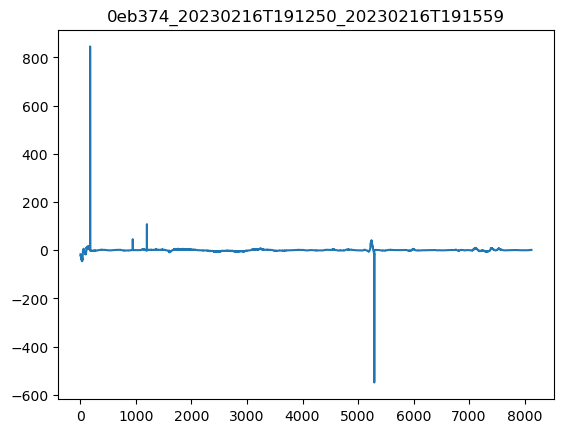

In [18]:
frames[0]['descent_diff'].plot(title=frames[0]['flightid'].iloc[0])

<AxesSubplot:title={'center':'0eb374_20230216T191746_20230216T192349'}>

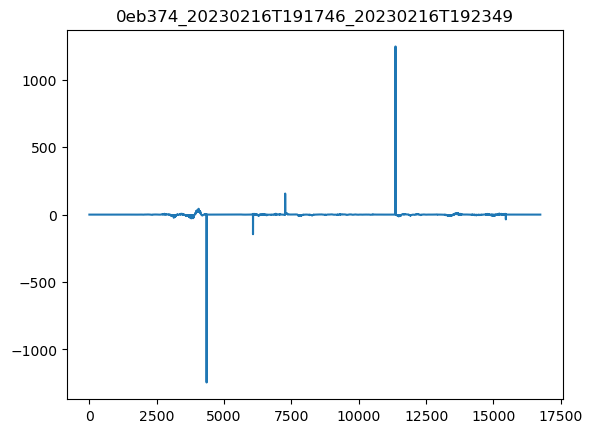

In [19]:
frames[2]['descent_diff'].plot(title=frames[2]['flightid'].iloc[0])

<AxesSubplot:title={'center':'0eb374_20230126T205028_20230126T205649'}>

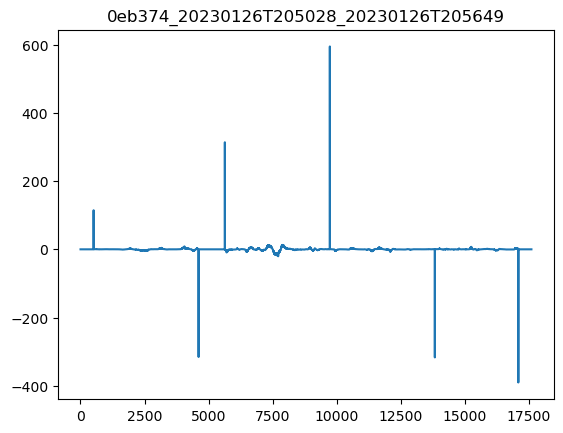

In [23]:
frames[3]['descent_diff'].plot(title=frames[3]['flightid'].iloc[0])

<AxesSubplot:title={'center':'0eb374_20221006T191600_20221006T192750'}>

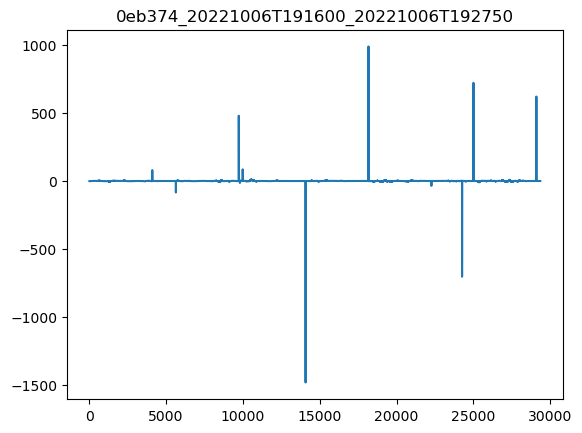

In [24]:
frames[4]['descent_diff'].plot(title=frames[4]['flightid'].iloc[0])

<AxesSubplot:title={'center':'0eb374_20230126T165108_20230126T170201'}>

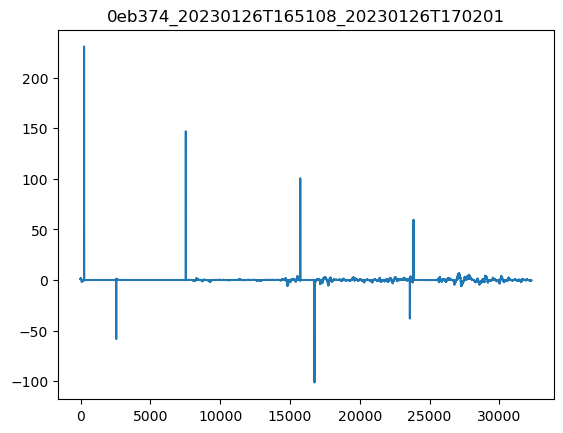

In [25]:
frames[5]['descent_diff'].plot(title=frames[5]['flightid'].iloc[0])

In [ ]:
frames[2]['descent_diff'].plot(title=frames[2]['flightid'].iloc[0])

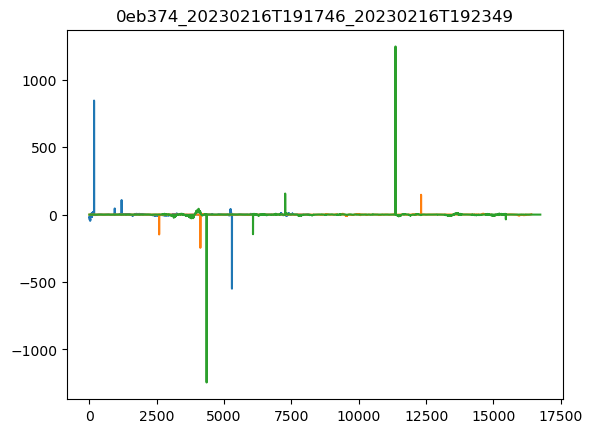

In [26]:
for i in range(len(frames[0:3])): 
    frames[i]['descent_diff'].plot(title=frames[i]['flightid'].iloc[0])

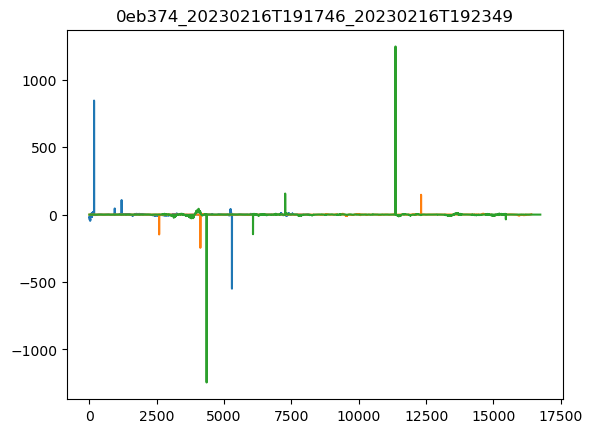

In [28]:
for i in range(len(frames[2:5])): 
    frames[i]['descent_diff'].plot(title=frames[i]['flightid'].iloc[0])

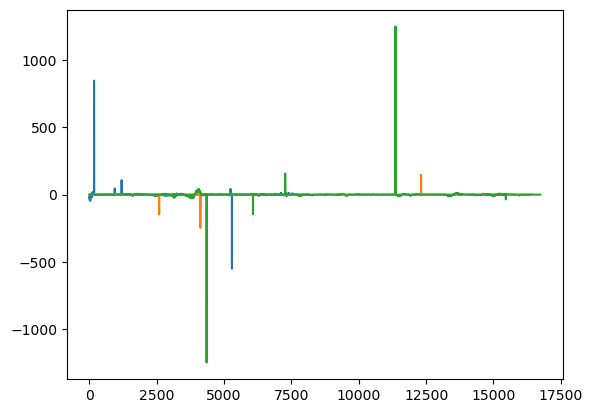

In [31]:
for frame in frames[0:3]:
    frame.descent_diff.plot()

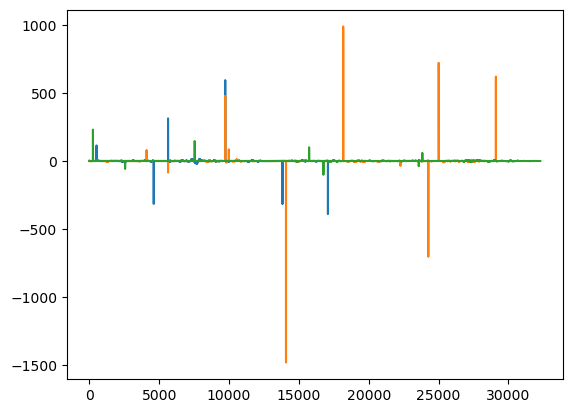

In [33]:
for frame in frames[3:6]:
    frame.descent_diff.plot()

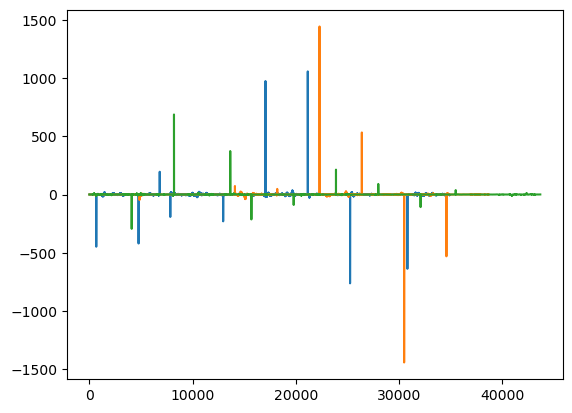

In [34]:
for frame in frames[6:9]:
    frame.descent_diff.plot()

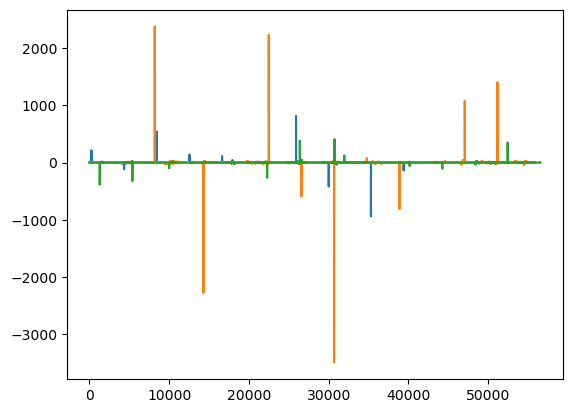

In [35]:
for frame in frames[9:12]:
    frame.descent_diff.plot()

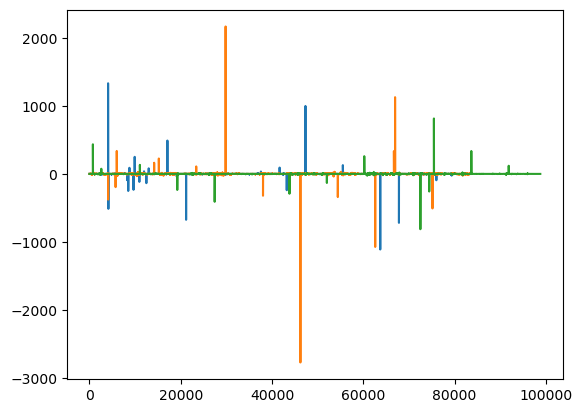

In [36]:
for frame in frames[12:15]:
    frame.descent_diff.plot()

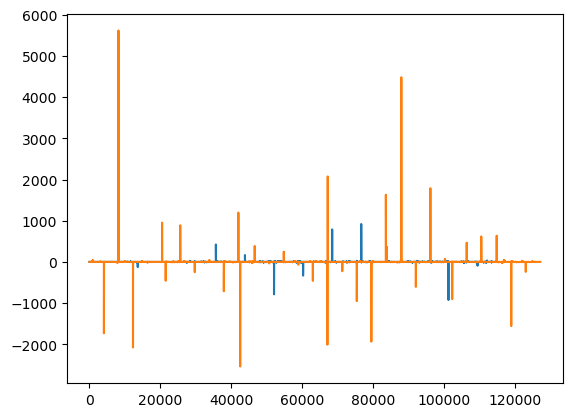

In [37]:
for frame in frames[15:18]:
    frame.descent_diff.plot()

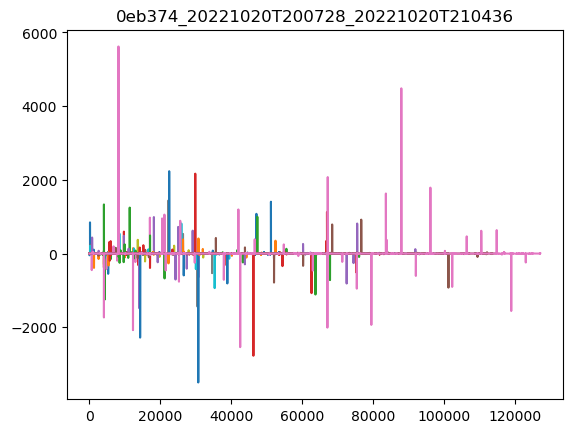

In [14]:
figs = [frames[i].descent_diff.plot(title=frames[i]['flightid'].iloc[0]).get_figure() for i in range(len(frames))]